In [1]:
from langgraph.graph import StateGraph ,START ,END
from langchain_core.prompts import PromptTemplate
from typing_extensions import TypedDict , Literal
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver


In [2]:
from pathlib import Path
folder_path = Path("./state_db")
folder_path.mkdir(parents=True, exist_ok=True)
db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [3]:
memory = SqliteSaver(conn)

In [4]:
from langchain_groq import ChatGroq
import os
groq_api_key = os.getenv("groq_api_key")
llm=ChatGroq(groq_api_key=groq_api_key,model_name="llama-3.1-8b-instant")

In [5]:
class User_details(TypedDict):
    name: str
    disease: str  
    phone_no: str
    payment_option: Literal["online", "offline"]


class Patient_about(TypedDict):
    name: str
    disease: str  
    phone_no: str
    payment_option: Literal["online", "offline"]
    user_prev_details:User_details
    user_current_details:User_details
    message : str



In [6]:
retrieval_prompt_template = """
You are form checker. Review and correct the given details:

Previous Form: {user_prev_details}

New Details:
- Name: {name}
- Disease: {disease}
- Phone Number: {phone_no}
- Payment Option: {payment_option}

If any information is missing, refer to the Previous Form.
make sure right key has right values in output
Verify and validate each detail before moving forward. """



retrieval_prompt = PromptTemplate.from_template(retrieval_prompt_template)

generation_prompt_template = """
Generate a structured form using the details below.

New Details:  
- name : {name}  
- disease: {disease}  
- phone_no: {phone_no}  
- payment_option: {payment_option}  

"""



generation_prompt = PromptTemplate.from_template(generation_prompt_template)
generation_llm = generation_prompt | llm.with_structured_output(User_details)
retrieve_data_llm = retrieval_prompt | llm.with_structured_output(User_details)


def retrieve_data(state:Patient_about):
    print("*"*35)
    print("retrieve_data")
    print("*"*35)
    name = input("name of the person")
    disease = input("disease of the person")
    phone_no = input("phone_no")
    payment_option = input("payment_option")
    return {"name":name,"disease":disease,"phone_no":phone_no,"payment_option":payment_option}


def data_incomplete(state:Patient_about):
    print("*"*35)
    print("data_incomplete")
    print("*"*35)
    
    name = state.get("name") or "Not provided"
    disease = state.get("disease") or "Not provided"
    phone_no = state.get("phone_no") or "Not provided"
    payment_option = state.get("payment_option") or "Not provided"
    user_prev_details = state.get("user_prev_details")

    print("values",name,disease)
   
    new_form = retrieve_data_llm.invoke({"name":name,"disease":disease,"phone_no":phone_no,"payment_option":payment_option,"user_prev_details":user_prev_details})
    return {"user_current_details":new_form}


def data_storing(state:Patient_about):
    print("*"*35)
    print("data_storing")
    print("*"*35)
    name = state.get("name","")
    disease = state.get("disease","")
    phone_no = state.get("phone_no","")
    payment_option = state.get("payment_option","")
    form = generation_llm.invoke({"name":name , "disease":disease , "phone_no":phone_no , "payment_option":payment_option})
    return {"user_current_details" : form}


def check_form(state:Patient_about):
    print("*"*35)
    print("following is your form")
    print(state["user_current_details"])
    print("*"*35)
    return {"user_prev_details" : state["user_current_details"]}



In [7]:
# conditional edges

def check_retrival(state: Patient_about):
    print("*"*35)
    print("check retrival")
    print("*"*35)
    name = state.get("name", "")
    disease = state.get("disease", "")
    phone_no = state.get("phone_no", "")
    payment_option = state.get("payment_option", "")
    if "" in (name, disease, phone_no, payment_option):
        return "data_incomplete"
    
    return "data_storing"


def data_verify(state:Patient_about):    
    option = input("a for again c for continue")
    if option == "c":
        return END
    else: 
        return "retrieve_data"


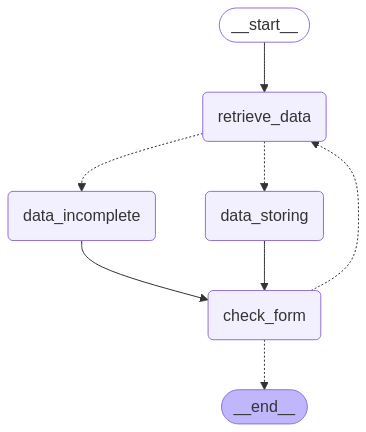

In [8]:
workflow = StateGraph(Patient_about)
# initializing nodes

# Nodes
workflow.add_node("retrieve_data",retrieve_data)
workflow.add_node("data_incomplete",data_incomplete)
workflow.add_node("data_storing",data_storing)
workflow.add_node("check_form",check_form)

# edges
workflow.add_edge(START,"retrieve_data")
workflow.add_conditional_edges("retrieve_data",check_retrival,["data_incomplete","data_storing"])
workflow.add_edge("data_incomplete","check_form")
workflow.add_edge("data_storing","check_form")
workflow.add_conditional_edges("check_form",data_verify,["retrieve_data",END])


graph = workflow.compile(checkpointer=memory)
graph

In [12]:
config = {"configurable": {"thread_id": "1"}}
result = graph.invoke({"name":""} ,config=config)

***********************************
retrieve_data
***********************************
***********************************
check retrival
***********************************
***********************************
data_incomplete
***********************************
values khush Not provided
***********************************
following is your form
{'name': 'khush', 'disease': 'headache', 'phone_no': '9818', 'payment_option': 'offline'}
***********************************
***********************************
retrieve_data
***********************************
***********************************
check retrival
***********************************
***********************************
data_incomplete
***********************************
values shefali Not provided
***********************************
following is your form
{'name': 'shefali', 'disease': 'headache', 'phone_no': '9818', 'payment_option': 'offline'}
***********************************


In [11]:
result

{'name': 'akshat',
 'disease': 'headache',
 'phone_no': '',
 'payment_option': '',
 'user_prev_details': {'name': 'akshat',
  'disease': 'headache',
  'phone_no': '9818',
  'payment_option': 'online'},
 'user_current_details': {'name': 'akshat',
  'disease': 'headache',
  'phone_no': '9818',
  'payment_option': 'online'}}